# Frontal Detection Analysis (Extreme Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime 
# Previously: needed cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
# This was resolved in nc-time-axis 1.3.0 (https://github.com/SciTools/nc-time-axis/releases/tag/v1.3.0)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='20GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus=1:mem=20GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 or 20 nodes (10 or 20 dask workers)
cluster.scale(20)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41638 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/41638/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/41638/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:39295,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/41638/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read and process fronts given input file

In [4]:
def process_fronts(path, file):
    fronts_ds = xr.open_dataset(path+file, chunks={'time':360})
    # convert longitudes to match CESM data (cons regrid)
    #fronts_ds_lons = fronts_ds.assign_coords(lon=(fronts_ds.lon % 360), keep_attrs=True)
    #fronts_ds_lons.lon.attrs = fronts_ds.lon.attrs
    #fronts = fronts_ds_lons.fronts
    fronts = fronts_ds.fronts
    # all fronts
    allfronts = fronts.argmax(dim='front')
    anyfront = allfronts.where(allfronts < 4) # masking out no front areas
    # cold fronts
    allcoldfronts = fronts.sel(front=0) # see fronts.front_type.values for indices
    anycoldfront = allcoldfronts.where(allcoldfronts == 1) # masking out no cold front areas
    # stationary fronts
    allstatfronts = fronts.sel(front=2) # see fronts.front_type.values for indices
    anystatfront = allstatfronts.where(allstatfronts == 1) # masking out no stationary front areas
    return(anyfront, anycoldfront, anystatfront)

In [5]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
fronts_file = "cesm_fronts_2000-2015_MaskedNetCDF_customgrid.nc"
fronts_full, cfronts_full, sfronts_full = process_fronts(cesm_fronts_filepath, fronts_file)

In [6]:
# subset for 2000-2014 for a 15-year climatology
#fronts = fronts_full.sel(time = slice("2000-01-01 03:00:00","2014-12-31 21:00:00")) # this doesn't work, don't know why (maybe cftime indexing?)
fronts = fronts_full[:43800]
fronts

<xarray.DataArray 'fronts' (time: 43800, lat: 68, lon: 141)>
dask.array<getitem, shape=(43800, 68, 141), dtype=float64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

In [7]:
cfronts = cfronts_full[:43800]
sfronts = sfronts_full[:43800]

In [8]:
fronts_file_rcp = "cesm_fronts_2086-2100_MaskedNetCDF_customgrid.nc"
fronts_rcp, cfronts_rcp, sfronts_rcp = process_fronts(cesm_fronts_filepath, fronts_file_rcp)
fronts_rcp

<xarray.DataArray 'fronts' (time: 43800, lat: 68, lon: 141)>
dask.array<where, shape=(43800, 68, 141), dtype=float64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

### Testing some alternates to calculate PEx (removing low precip days)

In [8]:
path = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc'
PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})

In [14]:
# units didn't save out after regridding; PRECT is m/s at 3hrly averages
convert=1000*60*60*3 # convert m/s to mm in each 3hr period
PRECT_1deg_day = (PRECT_1deg*convert).resample(time="1D").sum() # resample to daily values and sum over each day

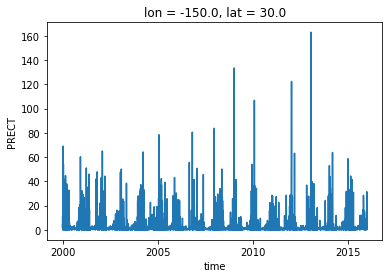

In [16]:
PRECT_1deg_day.sel(lat=30,lon=-150).plot()

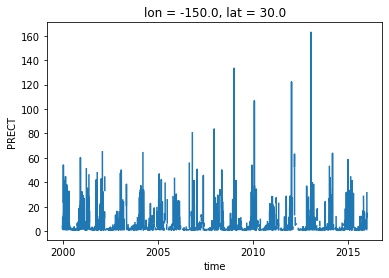

In [17]:
# filter out days with <1mm total precip
PRECT_1deg_day_filter = PRECT_1deg_day.where(PRECT_1deg_day > 1)
PRECT_1deg_day_filter.sel(lat=30,lon=-150).plot()

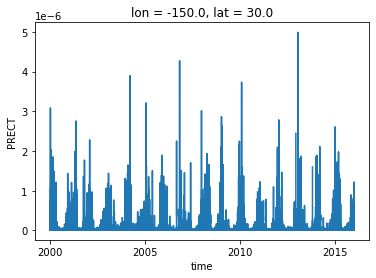

In [23]:
# problem is this is a daily timeseries, and I would need to isolate the filtered out days and remove them from PRECT_1deg timeseries which is 3hrly
#PRECT_1deg.where(PRECT_1deg_day > 1) # this works but it gives me a daily timeseries
PRECT_1deg_filter = PRECT_1deg.where((PRECT_1deg*convert) > 1/8) # here, remove 3hrly timesteps with <1/8 mm assuming even spread (8 time steps per day)
PRECT_1deg_filter.sel(lat=30,lon=-150).plot()
# but is this fair to then later look at monthly climatologies because only certain 3hrly timesteps are removed (could be only part of a day)?
# makes the results very noisy, probably due to the uneven temporal sampling

## Read landfrac to subset land points

In [9]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
landfrac_file = 'landfrac_1deg_bil.nc'

In [10]:
landfrac = xr.open_dataarray(postprocessing_filepath+landfrac_file)
landfrac

<xarray.DataArray 'LANDFRAC' (lat: 68, lon: 141)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
Attributes:
    regrid_method:  bilinear

## Read and process extreme precipitation given input file and percentile

In [11]:
def process_PEx(path, file, landfrac, percentile):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    
    # remove low PRECT amounts (optional, not sure this is advisable as done here)
    #convert = 1000*60*60*3 # convert m/s to mm in each 3hr period
    #PRECT_1deg = PRECT_1deg.where((PRECT_1deg*convert) > 1/8) # here, remove 3hrly timesteps with <1/8 mm assuming even spread (8 time steps per day)
    
    # subset for land only (optional; comment out to use whole domain)
    PRECT_1deg = PRECT_1deg.where(landfrac > 0)
    
    quantile = percentile/100
    
    # PEx over space
    pX = PRECT_1deg.chunk({'time': -1}).quantile(quantile, dim='time')
    PEx = PRECT_1deg.where(PRECT_1deg > pX)
    # subset for CONUS
    PEx_CONUS = PEx.sel(lat=slice(26,50), lon=slice(-125,-68)) # MERRA lons
    #PEx_CONUS = PEx.sel(lat=slice(26,50), lon=slice(235,292)) # CESM lons
    
    # PEx over time
    pX_time = PRECT_1deg.chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    PEx_time = PRECT_1deg.where(PRECT_1deg > pX_time)
    
    # subset for CONUS, starting from quantile calculation since it's looking over space
    # MERRA lons
    pX_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    PEx_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).where(PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)) > pX_time_CONUS)
    # CESM lons
    #pX_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(235,292)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    #PEx_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(235,292)).where(PRECT_1deg.sel(lat=slice(26,50), lon=slice(235,292)) > pX_time_CONUS)
    
    return(PEx, PEx_CONUS, PEx_time, PEx_time_CONUS)

In [59]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc' # bilinear interpolation
#PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_cons.nc' # conservative regridding
# toggle this to test different PEx definitions
#percentile = 90
#percentile = 95
percentile = 99
PEx, PEx_CONUS, PEx_time, PEx_time_CONUS = process_PEx(postprocessing_filepath, PRECT_file, landfrac, percentile)
PEx

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43800, 68, 141)","(600, 10, 20)"
Count,21282 Tasks,4088 Chunks
Type,float64,numpy.ndarray


In [13]:
# modify processing function to account for using a different baseline
def process_PEx_base(path, file, basefile, landfrac, percentile):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    PRECT_1deg_base = xr.open_dataarray(path+basefile, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    if PRECT_1deg_base.shape[0] > 43800:
        PRECT_1deg_base = PRECT_1deg_base[:43800]
        
    # subset for land only (optional; comment out to use whole domain)
    PRECT_1deg = PRECT_1deg.where(landfrac > 0)
    PRECT_1deg_base = PRECT_1deg_base.where(landfrac > 0)

    quantile = percentile/100
    
    # PEx over space
    #pX = PRECT_1deg.chunk({'time': -1}).quantile(quantile, dim='time')
    pX = PRECT_1deg_base.chunk({'time': -1}).quantile(quantile, dim='time') # use the baseline file to define the percentile
    PEx = PRECT_1deg.where(PRECT_1deg > pX)
    # subset for CONUS
    PEx_CONUS = PEx.sel(lat=slice(26,50), lon=slice(-125,-68)) # MERRA lons
    #PEx_CONUS = PEx.sel(lat=slice(26,50), lon=slice(235,292)) # CESM lons
    
    # PEx over time
    #pX_time = PRECT_1deg.chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    pX_time = PRECT_1deg_base.chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    # copy the time attribute from PRECT_1deg to pX_time so they will match
    pX_time = pX_time.assign_coords(time=PRECT_1deg.time)
    PEx_time = PRECT_1deg.where(PRECT_1deg > pX_time) 
    
    # subset for CONUS, starting from quantile calculation since it's looking over space
    # MERRA lons
    pX_time_CONUS = PRECT_1deg_base.sel(lat=slice(26,50), lon=slice(-125,-68)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    pX_time_CONUS = pX_time_CONUS.assign_coords(time=PRECT_1deg.time)
    PEx_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)).where(PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68)) > pX_time_CONUS)
    # CESM lons
    #pX_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(235,292)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    #pX_time_CONUS = PRECT_1deg_base.sel(lat=slice(26,50), lon=slice(235,292)).chunk({'lat': -1, 'lon': -1}).quantile(quantile, dim=('lat','lon'))
    #pX_time_CONUS = pX_time_CONUS.assign_coords(time=PRECT_1deg.time)
    #PEx_time_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(235,292)).where(PRECT_1deg.sel(lat=slice(26,50), lon=slice(235,292)) > pX_time_CONUS)
    
    return(PEx, PEx_CONUS, PEx_time, PEx_time_CONUS)

In [60]:
PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_bil.nc'
#PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_cons.nc'
PEx_rcp, PEx_CONUS_rcp, PEx_time_rcp, PEx_time_CONUS_rcp = process_PEx_base(postprocessing_filepath, file=PRECT_file_rcp, basefile=PRECT_file, landfrac=landfrac, percentile=percentile)
PEx_rcp

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43800, 68, 141)","(600, 10, 20)"
Count,29459 Tasks,4088 Chunks
Type,float64,numpy.ndarray


## Calculate percent gridpoints that overlap given fronts and PEx
Also return PEx gridpoints

In [15]:
def calc_overlap_space(fronts,cfronts,sfronts,PEx):
    PEx_front = PEx.where(fronts.notnull())
    PEx_cfront = PEx.where(cfronts.notnull())
    PEx_sfront = PEx.where(sfronts.notnull())
    
    PExgridpoints = PEx.notnull().sum(dim=('lat','lon'))
    overlap = PEx_front.notnull().sum(dim=('lat','lon'))
    overlap_c = PEx_cfront.notnull().sum(dim=('lat','lon'))
    overlap_s = PEx_sfront.notnull().sum(dim=('lat','lon'))
    npercentPEx = 100*(overlap/PExgridpoints)
    npercentPEx_c = 100*(overlap_c/PExgridpoints)
    npercentPEx_s = 100*(overlap_s/PExgridpoints)
    
    return(npercentPEx, npercentPEx_c, npercentPEx_s, PExgridpoints)

In [61]:
npercentPEx_space, npercentPEx_c_space, npercentPEx_s_space, PExgridpoints_space = calc_overlap_space(fronts, cfronts, sfronts, PEx)
npercentPEx_space_CONUS, npercentPEx_c_space_CONUS, npercentPEx_s_space_CONUS, PExgridpoints_space_CONUS = calc_overlap_space(fronts, cfronts, sfronts, PEx_CONUS)
npercentPEx_space_rcp, npercentPEx_c_space_rcp, npercentPEx_s_space_rcp, PExgridpoints_space_rcp = calc_overlap_space(fronts_rcp, cfronts_rcp, sfronts_rcp, PEx_rcp)
npercentPEx_space_CONUS_rcp, npercentPEx_c_space_CONUS_rcp, npercentPEx_s_space_CONUS_rcp, PExgridpoints_space_CONUS_rcp = calc_overlap_space(fronts_rcp, cfronts_rcp, sfronts_rcp, PEx_CONUS_rcp)

In [17]:
def calc_overlap_time(fronts,cfronts,sfronts,PEx):
    PEx_front = PEx.where(fronts.notnull())
    PEx_cfront = PEx.where(cfronts.notnull())
    PEx_sfront = PEx.where(sfronts.notnull())
    
    PExgridpoints = PEx.notnull().sum(dim='time')
    overlap = PEx_front.notnull().sum(dim='time')
    overlap_c = PEx_cfront.notnull().sum(dim=('lat','lon'))
    overlap_s = PEx_sfront.notnull().sum(dim=('lat','lon'))
    npercentPEx = 100*(overlap/PExgridpoints)
    npercentPEx_c = 100*(overlap_c/PExgridpoints)
    npercentPEx_s = 100*(overlap_s/PExgridpoints)
    
    PExgridpoints_byseason = PEx.notnull().groupby("time.season").sum(dim='time') # by season (4; DJF, JJA, MAM, SON)
    overlap_byseason = PEx_front.notnull().groupby("time.season").sum(dim='time')
    overlap_c_byseason = PEx_cfront.notnull().groupby("time.season").sum(dim='time')
    overlap_s_byseason = PEx_sfront.notnull().groupby("time.season").sum(dim='time')
    npercentPEx_byseason = 100*(overlap_byseason/PExgridpoints_byseason)
    npercentPEx_c_byseason = 100*(overlap_c_byseason/PExgridpoints_byseason)
    npercentPEx_s_byseason = 100*(overlap_s_byseason/PExgridpoints_byseason)
    
    return(npercentPEx, npercentPEx_c, npercentPEx_s, npercentPEx_byseason, npercentPEx_c_byseason, npercentPEx_s_byseason, PExgridpoints, PExgridpoints_byseason)

In [62]:
npercentPEx_time, npercentPEx_c_time, npercentPEx_s_time, npercentPEx_time_byseason, npercentPEx_c_time_byseason, npercentPEx_s_time_byseason, PExgridpoints_time, PExgridpoints_time_byseason = calc_overlap_time(fronts, cfronts, sfronts, PEx_time)
npercentPEx_time_CONUS, npercentPEx_c_time_CONUS, npercentPEx_s_time_CONUS, npercentPEx_time_CONUS_byseason, npercentPEx_c_time_CONUS_byseason, npercentPEx_s_time_CONUS_byseason, PExgridpoints_time_CONUS, PExgridpoints_time_CONUS_byseason = calc_overlap_time(fronts, cfronts, sfronts, PEx_time_CONUS)
npercentPEx_time_rcp, npercentPEx_c_time_rcp, npercentPEx_s_time_rcp, npercentPEx_time_byseason_rcp, npercentPEx_c_time_byseason_rcp, npercentPEx_s_time_byseason_rcp, PExgridpoints_time_rcp, PExgridpoints_time_byseason_rcp = calc_overlap_time(fronts_rcp, cfronts_rcp, sfronts_rcp, PEx_time_rcp)
npercentPEx_time_CONUS_rcp, npercentPEx_c_time_CONUS_rcp, npercentPEx_s_time_CONUS_rcp, npercentPEx_time_CONUS_byseason_rcp, npercentPEx_c_time_CONUS_byseason_rcp, npercentPEx_s_time_CONUS_byseason_rcp, PExgridpoints_time_CONUS_rcp, PExgridpoints_time_CONUS_byseason_rcp = calc_overlap_time(fronts_rcp, cfronts_rcp, sfronts_rcp, PEx_time_CONUS_rcp)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 56
  result = blockwise(
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 56
  result = blockwise(
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 56
  result = blockwise(
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:4351: PerformanceWarning: Incr

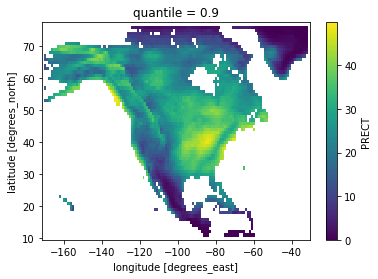

In [19]:
# this is a masked array
npercentPEx_time.plot()

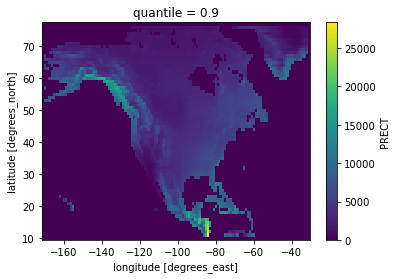

In [20]:
# this is not a masked array! because of the summing? though not sure why npercentPEx_time would be masked then
PExgridpoints_time.plot()

### Climatological monthly mean plots

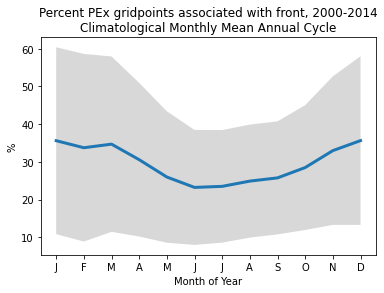

In [63]:
npercentPEx_monthofyear = npercentPEx_space.groupby("time.month").mean().persist()
npercentPEx_monthofyear_std = npercentPEx_space.groupby("time.month").std().persist()

plt.plot(npercentPEx_monthofyear.month, npercentPEx_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_monthofyear.month, npercentPEx_monthofyear-npercentPEx_monthofyear_std, 
                npercentPEx_monthofyear+npercentPEx_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2000-2014\nClimatological Monthly Mean Annual Cycle');

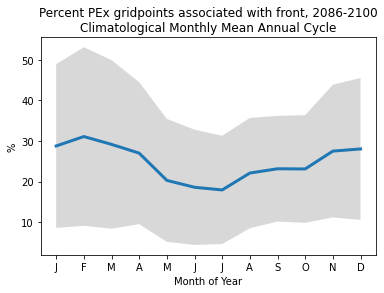

In [64]:
npercentPEx_rcp85_monthofyear = npercentPEx_space_rcp.groupby("time.month").mean().persist()
npercentPEx_rcp85_monthofyear_std = npercentPEx_space_rcp.groupby("time.month").std().persist()

plt.plot(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear, linewidth=3)
plt.fill_between(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear-npercentPEx_rcp85_monthofyear_std, 
                npercentPEx_rcp85_monthofyear+npercentPEx_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2086-2100\nClimatological Monthly Mean Annual Cycle');

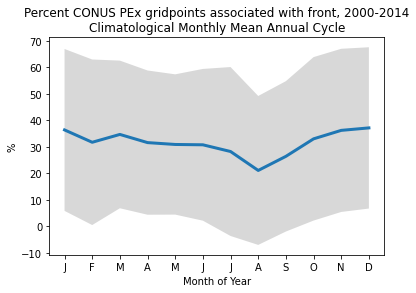

In [65]:
npercentPEx_monthofyear_CONUS = npercentPEx_space_CONUS.groupby("time.month").mean().persist()
npercentPEx_monthofyear_std_CONUS = npercentPEx_space_CONUS.groupby("time.month").std().persist()

plt.plot(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS, linewidth=3)
plt.fill_between(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS-npercentPEx_monthofyear_std_CONUS, 
                npercentPEx_monthofyear_CONUS+npercentPEx_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent CONUS PEx gridpoints associated with front, 2000-2014\nClimatological Monthly Mean Annual Cycle');

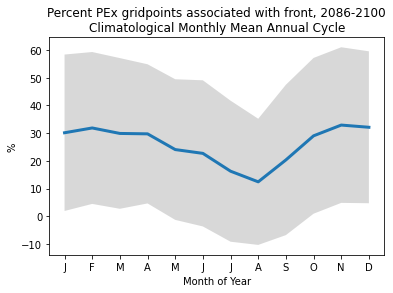

In [66]:
npercentPEx_rcp85_monthofyear_CONUS = npercentPEx_space_CONUS_rcp.groupby("time.month").mean().persist()
npercentPEx_rcp85_monthofyear_std_CONUS = npercentPEx_space_CONUS_rcp.groupby("time.month").std().persist()

plt.plot(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS, linewidth=3)
plt.fill_between(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS-npercentPEx_rcp85_monthofyear_std_CONUS, 
                npercentPEx_rcp85_monthofyear_CONUS+npercentPEx_rcp85_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front, 2086-2100\nClimatological Monthly Mean Annual Cycle');

In [67]:
# calculate differences, rcp-hist
npercentPEx_monthofyear_CONUS_diff = npercentPEx_rcp85_monthofyear_CONUS - npercentPEx_monthofyear_CONUS
npercentPEx_monthofyear_diff = npercentPEx_rcp85_monthofyear - npercentPEx_monthofyear

### Panel the climatology plots

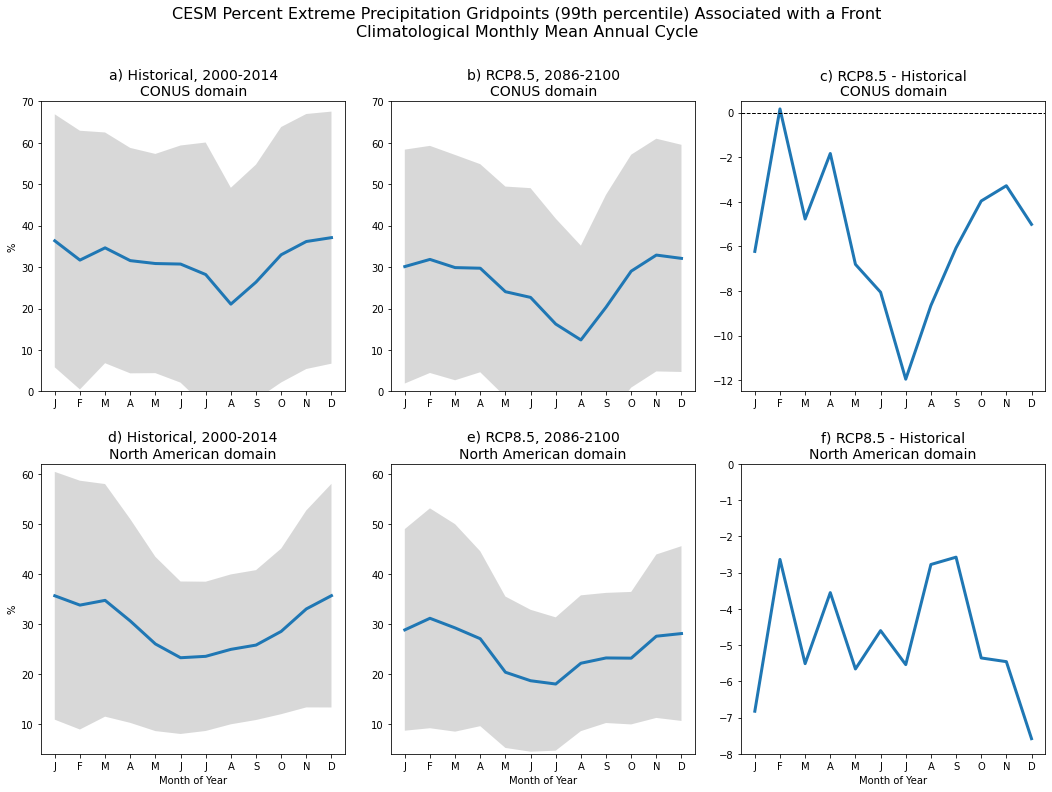

In [68]:
fig, axs = plt.subplots(2, 3, figsize=(18,12))

# CONUS, hist
axs[0,0].plot(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS, linewidth=3)
axs[0,0].fill_between(npercentPEx_monthofyear_CONUS.month, npercentPEx_monthofyear_CONUS-npercentPEx_monthofyear_std_CONUS, 
                npercentPEx_monthofyear_CONUS+npercentPEx_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,0].set_xticks(np.arange(12)+1)
axs[0,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,0].set_ylim(10,50) # 90th
#axs[0,0].set_ylim(5,60) # 95th
#axs[0,0].set_ylim(0,75) # 99th
#axs[0,0].set_ylim(8,46) # 90th, land only
#axs[0,0].set_ylim(4,55) # 95th, land only
axs[0,0].set_ylim(0,70) # 99th, land only
axs[0,0].set_ylabel('%')
axs[0,0].set_title('a) Historical, 2000-2014\nCONUS domain', fontsize=14)

# CONUS, rcp
axs[0,1].plot(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS, linewidth=3)
axs[0,1].fill_between(npercentPEx_rcp85_monthofyear_CONUS.month, npercentPEx_rcp85_monthofyear_CONUS-npercentPEx_rcp85_monthofyear_std_CONUS, 
                npercentPEx_rcp85_monthofyear_CONUS+npercentPEx_rcp85_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,1].set_xticks(np.arange(12)+1) 
axs[0,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,1].set_ylim(10,50)
#axs[0,1].set_ylim(5,60)
#axs[0,1].set_ylim(0,75)
# land only
#axs[0,1].set_ylim(8,46)
#axs[0,1].set_ylim(4,55)
axs[0,1].set_ylim(0,70)
axs[0,1].set_title('b) RCP8.5, 2086-2100\nCONUS domain', fontsize=14);

# CONUS, diff
axs[0,2].plot(npercentPEx_monthofyear_CONUS_diff.month, npercentPEx_monthofyear_CONUS_diff, linewidth=3)
axs[0,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[0,2].set_xticks(np.arange(12)+1) 
axs[0,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,2].set_ylim(-5,0)
#axs[0,2].set_ylim(-7,0)
#axs[0,2].set_ylim(-13,0)
# land only
#axs[0,2].set_ylim(-4,1)
#axs[0,2].set_ylim(-6,1)
axs[0,2].set_ylim(-12.5,0.5)
axs[0,2].set_title('c) RCP8.5 - Historical\nCONUS domain', fontsize=14);

# NA, hist
axs[1,0].plot(npercentPEx_monthofyear.month, npercentPEx_monthofyear, linewidth=3)
axs[1,0].fill_between(npercentPEx_monthofyear.month, npercentPEx_monthofyear-npercentPEx_monthofyear_std, 
                npercentPEx_monthofyear+npercentPEx_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,0].set_xticks(np.arange(12)+1)
axs[1,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,0].set_xlabel('Month of Year')
#axs[1,0].set_ylim(12,40)
#axs[1,0].set_ylim(10,50)
#axs[1,0].set_ylim(8,68)
# land only
#axs[1,0].set_ylim(8,36)
#axs[1,0].set_ylim(10,43)
axs[1,0].set_ylim(4,62)
axs[1,0].set_ylabel('%')
axs[1,0].set_title('d) Historical, 2000-2014\nNorth American domain', fontsize=14);
#axs[1,0].set_title('North American domain', fontsize=14);

# NA, rcp
axs[1,1].plot(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear, linewidth=3)
axs[1,1].fill_between(npercentPEx_rcp85_monthofyear.month, npercentPEx_rcp85_monthofyear-npercentPEx_rcp85_monthofyear_std, 
                npercentPEx_rcp85_monthofyear+npercentPEx_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,1].set_xticks(np.arange(12)+1)
axs[1,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,1].set_xlabel('Month of Year')
#axs[1,1].set_ylim(12,40)
#axs[1,1].set_ylim(10,50)
#axs[1,1].set_ylim(8,68)
# land only
#axs[1,1].set_ylim(8,36)
#axs[1,1].set_ylim(10,43)
axs[1,1].set_ylim(4,62)
axs[1,1].set_title('e) RCP8.5, 2086-2100\nNorth American domain', fontsize=14);
#axs[1,1].set_title('North American domain', fontsize=14);

# NA, diff
axs[1,2].plot(npercentPEx_monthofyear_diff.month, npercentPEx_monthofyear_diff, linewidth=3)
#axs[1,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[1,2].set_xticks(np.arange(12)+1) 
axs[1,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,2].set_xlabel('Month of Year')
#axs[1,2].set_ylim(-6,0)
#axs[1,2].set_ylim(-7,0)
#axs[1,2].set_ylim(-7,0)
# land only
#axs[1,2].set_ylim(-8,0)
#axs[1,2].set_ylim(-9,0)
axs[1,2].set_ylim(-8,0)
axs[1,2].set_title('f) RCP8.5 - Historical\nNorth American domain', fontsize=14);
#axs[1,2].set_title('North American domain', fontsize=14);

#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)
#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (95th percentile) Associated with a Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (99th percentile) Associated with a Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)

plt.subplots_adjust(wspace=0.15, hspace=0.25)

#plt.savefig('../figures/toSCP/npercentPEx_monthofyear_compare_withdiff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_monthofyear_compare_withdiff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_monthofyear_compare_withdiff.png', bbox_inches='tight')
# plots with altered PEx baseline for RCP simulation
#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_monthofyear_compare_withdiff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_monthofyear_compare_withdiff_alterbase.png', bbox_inches='tight')
# plot with PRECT conservative regridding
#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_alterbase_consregrid.png', bbox_inches='tight')
# plot land points only
#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_alterbase_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_monthofyear_compare_withdiff_alterbase_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_monthofyear_compare_withdiff_alterbase_landonly.png', bbox_inches='tight')

#### Cold fronts

In [147]:
npercentPEx_c_monthofyear = npercentPEx_c_space.groupby("time.month").mean().persist()
npercentPEx_c_monthofyear_std = npercentPEx_c_space.groupby("time.month").std().persist()
npercentPEx_c_rcp85_monthofyear = npercentPEx_c_space_rcp.groupby("time.month").mean().persist()
npercentPEx_c_rcp85_monthofyear_std = npercentPEx_c_space_rcp.groupby("time.month").std().persist()
npercentPEx_c_monthofyear_CONUS = npercentPEx_c_space_CONUS.groupby("time.month").mean().persist()
npercentPEx_c_monthofyear_std_CONUS = npercentPEx_c_space_CONUS.groupby("time.month").std().persist()
npercentPEx_c_rcp85_monthofyear_CONUS = npercentPEx_c_space_CONUS_rcp.groupby("time.month").mean().persist()
npercentPEx_c_rcp85_monthofyear_std_CONUS = npercentPEx_c_space_CONUS_rcp.groupby("time.month").std().persist()

In [148]:
npercentPEx_c_monthofyear_CONUS_diff = npercentPEx_c_rcp85_monthofyear_CONUS - npercentPEx_c_monthofyear_CONUS
npercentPEx_c_monthofyear_diff = npercentPEx_c_rcp85_monthofyear - npercentPEx_c_monthofyear

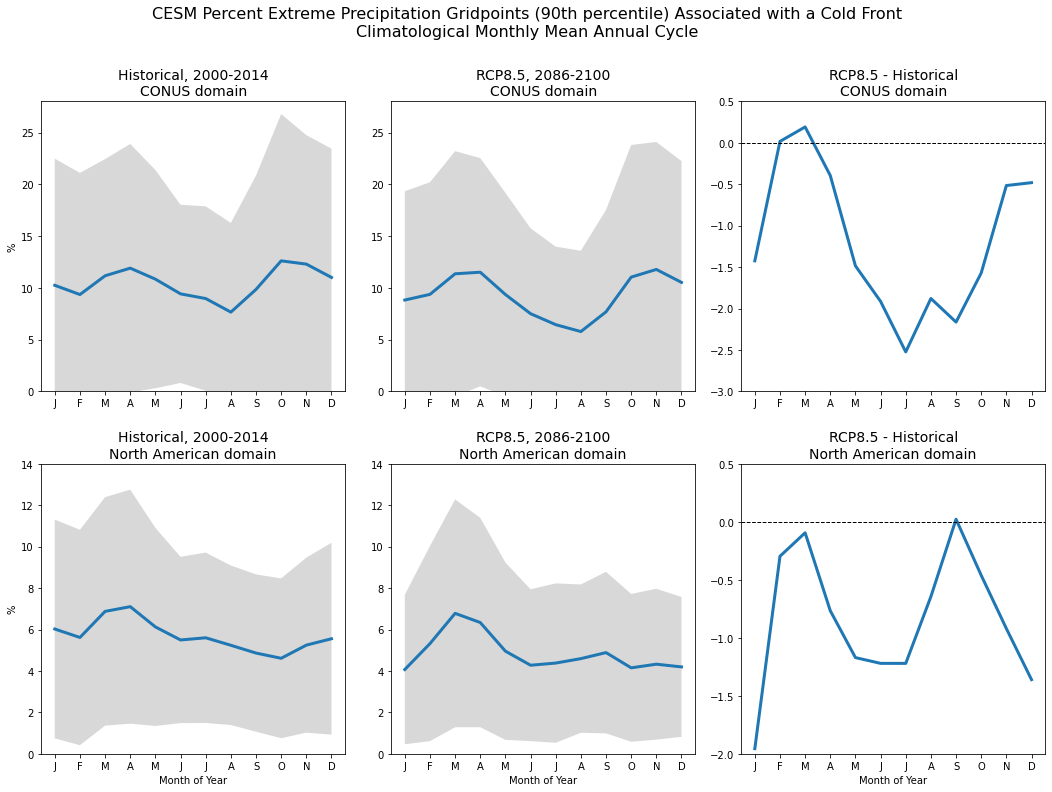

In [149]:
fig, axs = plt.subplots(2, 3, figsize=(18,12))

# CONUS, hist
axs[0,0].plot(npercentPEx_c_monthofyear_CONUS.month, npercentPEx_c_monthofyear_CONUS, linewidth=3)
axs[0,0].fill_between(npercentPEx_c_monthofyear_CONUS.month, npercentPEx_c_monthofyear_CONUS-npercentPEx_c_monthofyear_std_CONUS, 
                npercentPEx_c_monthofyear_CONUS+npercentPEx_c_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,0].set_xticks(np.arange(12)+1)
axs[0,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,0].set_ylim(0,30) # 90th
axs[0,0].set_ylim(0,28) # 90th, land only
axs[0,0].set_ylabel('%')
axs[0,0].set_title('Historical, 2000-2014\nCONUS domain', fontsize=14)

# CONUS, rcp
axs[0,1].plot(npercentPEx_c_rcp85_monthofyear_CONUS.month, npercentPEx_c_rcp85_monthofyear_CONUS, linewidth=3)
axs[0,1].fill_between(npercentPEx_c_rcp85_monthofyear_CONUS.month, npercentPEx_c_rcp85_monthofyear_CONUS-npercentPEx_c_rcp85_monthofyear_std_CONUS, 
                npercentPEx_c_rcp85_monthofyear_CONUS+npercentPEx_c_rcp85_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,1].set_xticks(np.arange(12)+1) 
axs[0,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,1].set_ylim(0,30)
axs[0,1].set_ylim(0,28)
axs[0,1].set_title('RCP8.5, 2086-2100\nCONUS domain', fontsize=14);

# CONUS, diff
axs[0,2].plot(npercentPEx_c_monthofyear_CONUS_diff.month, npercentPEx_c_monthofyear_CONUS_diff, linewidth=3)
axs[0,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[0,2].set_xticks(np.arange(12)+1) 
axs[0,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,2].set_ylim(-3.5,0)
axs[0,2].set_ylim(-3,0.5)
axs[0,2].set_title('RCP8.5 - Historical\nCONUS domain', fontsize=14);

# NA, hist
axs[1,0].plot(npercentPEx_c_monthofyear.month, npercentPEx_c_monthofyear, linewidth=3)
axs[1,0].fill_between(npercentPEx_c_monthofyear.month, npercentPEx_c_monthofyear-npercentPEx_c_monthofyear_std, 
                npercentPEx_c_monthofyear+npercentPEx_c_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,0].set_xticks(np.arange(12)+1)
axs[1,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,0].set_xlabel('Month of Year')
#axs[1,0].set_ylim(0,18)
axs[1,0].set_ylim(0,14)
axs[1,0].set_ylabel('%')
axs[1,0].set_title('Historical, 2000-2014\nNorth American domain', fontsize=14);

# NA, rcp
axs[1,1].plot(npercentPEx_c_rcp85_monthofyear.month, npercentPEx_c_rcp85_monthofyear, linewidth=3)
axs[1,1].fill_between(npercentPEx_c_rcp85_monthofyear.month, npercentPEx_c_rcp85_monthofyear-npercentPEx_c_rcp85_monthofyear_std, 
                npercentPEx_c_rcp85_monthofyear+npercentPEx_c_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,1].set_xticks(np.arange(12)+1)
axs[1,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,1].set_xlabel('Month of Year')
#axs[1,1].set_ylim(0,18)
axs[1,1].set_ylim(0,14)
axs[1,1].set_title('RCP8.5, 2086-2100\nNorth American domain', fontsize=14);

# NA, diff
axs[1,2].plot(npercentPEx_c_monthofyear_diff.month, npercentPEx_c_monthofyear_diff, linewidth=3)
axs[1,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[1,2].set_xticks(np.arange(12)+1) 
axs[1,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,2].set_xlabel('Month of Year')
#axs[1,2].set_ylim(-2.5,0)
axs[1,2].set_ylim(-2,0.5)
axs[1,2].set_title('RCP8.5 - Historical\nNorth American domain', fontsize=14);

fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Cold Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)

plt.subplots_adjust(wspace=0.15, hspace=0.25)

#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_cold_fronts.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_cold_fronts_landonly.png', bbox_inches='tight')

#### Stationary fronts

In [150]:
npercentPEx_s_monthofyear = npercentPEx_s_space.groupby("time.month").mean().persist()
npercentPEx_s_monthofyear_std = npercentPEx_s_space.groupby("time.month").std().persist()
npercentPEx_s_rcp85_monthofyear = npercentPEx_s_space_rcp.groupby("time.month").mean().persist()
npercentPEx_s_rcp85_monthofyear_std = npercentPEx_s_space_rcp.groupby("time.month").std().persist()
npercentPEx_s_monthofyear_CONUS = npercentPEx_s_space_CONUS.groupby("time.month").mean().persist()
npercentPEx_s_monthofyear_std_CONUS = npercentPEx_s_space_CONUS.groupby("time.month").std().persist()
npercentPEx_s_rcp85_monthofyear_CONUS = npercentPEx_s_space_CONUS_rcp.groupby("time.month").mean().persist()
npercentPEx_s_rcp85_monthofyear_std_CONUS = npercentPEx_s_space_CONUS_rcp.groupby("time.month").std().persist()

In [151]:
npercentPEx_s_monthofyear_CONUS_diff = npercentPEx_s_rcp85_monthofyear_CONUS - npercentPEx_s_monthofyear_CONUS
npercentPEx_s_monthofyear_diff = npercentPEx_s_rcp85_monthofyear - npercentPEx_s_monthofyear

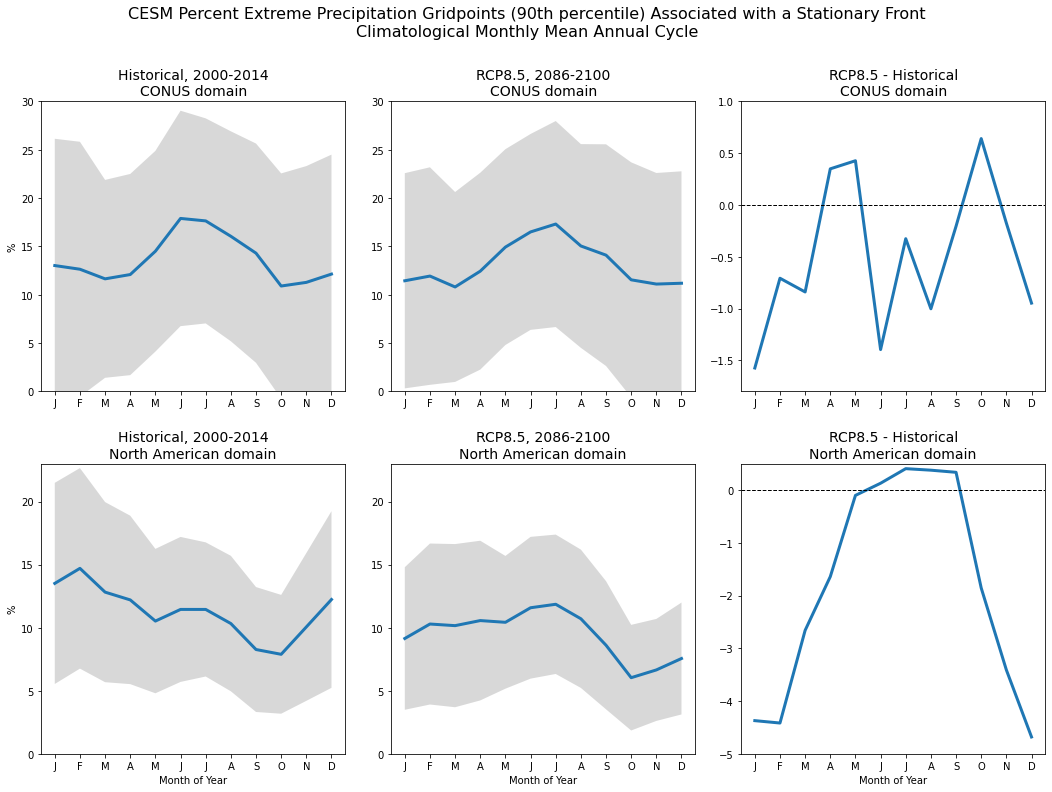

In [152]:
fig, axs = plt.subplots(2, 3, figsize=(18,12))

# CONUS, hist
axs[0,0].plot(npercentPEx_s_monthofyear_CONUS.month, npercentPEx_s_monthofyear_CONUS, linewidth=3)
axs[0,0].fill_between(npercentPEx_s_monthofyear_CONUS.month, npercentPEx_s_monthofyear_CONUS-npercentPEx_s_monthofyear_std_CONUS, 
                npercentPEx_s_monthofyear_CONUS+npercentPEx_s_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,0].set_xticks(np.arange(12)+1)
axs[0,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[0,0].set_ylim(0,30) # 90th
axs[0,0].set_ylabel('%')
axs[0,0].set_title('Historical, 2000-2014\nCONUS domain', fontsize=14)

# CONUS, rcp
axs[0,1].plot(npercentPEx_s_rcp85_monthofyear_CONUS.month, npercentPEx_s_rcp85_monthofyear_CONUS, linewidth=3)
axs[0,1].fill_between(npercentPEx_s_rcp85_monthofyear_CONUS.month, npercentPEx_s_rcp85_monthofyear_CONUS-npercentPEx_s_rcp85_monthofyear_std_CONUS, 
                npercentPEx_s_rcp85_monthofyear_CONUS+npercentPEx_s_rcp85_monthofyear_std_CONUS, alpha=0.3, facecolor='grey')
axs[0,1].set_xticks(np.arange(12)+1) 
axs[0,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[0,1].set_ylim(0,30)
axs[0,1].set_title('RCP8.5, 2086-2100\nCONUS domain', fontsize=14);

# CONUS, diff
axs[0,2].plot(npercentPEx_s_monthofyear_CONUS_diff.month, npercentPEx_s_monthofyear_CONUS_diff, linewidth=3)
axs[0,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[0,2].set_xticks(np.arange(12)+1) 
axs[0,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#axs[0,2].set_ylim(-2,0.5)
axs[0,2].set_ylim(-1.8,1) # 90th, land only
axs[0,2].set_title('RCP8.5 - Historical\nCONUS domain', fontsize=14);

# NA, hist
axs[1,0].plot(npercentPEx_s_monthofyear.month, npercentPEx_s_monthofyear, linewidth=3)
axs[1,0].fill_between(npercentPEx_s_monthofyear.month, npercentPEx_s_monthofyear-npercentPEx_s_monthofyear_std, 
                npercentPEx_s_monthofyear+npercentPEx_s_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,0].set_xticks(np.arange(12)+1)
axs[1,0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,0].set_xlabel('Month of Year')
#axs[1,0].set_ylim(2,16)
axs[1,0].set_ylim(0,23)
axs[1,0].set_ylabel('%')
axs[1,0].set_title('Historical, 2000-2014\nNorth American domain', fontsize=14);

# NA, rcp
axs[1,1].plot(npercentPEx_s_rcp85_monthofyear.month, npercentPEx_s_rcp85_monthofyear, linewidth=3)
axs[1,1].fill_between(npercentPEx_s_rcp85_monthofyear.month, npercentPEx_s_rcp85_monthofyear-npercentPEx_s_rcp85_monthofyear_std, 
                npercentPEx_s_rcp85_monthofyear+npercentPEx_s_rcp85_monthofyear_std, alpha=0.3, facecolor='grey')
axs[1,1].set_xticks(np.arange(12)+1)
axs[1,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,1].set_xlabel('Month of Year')
#axs[1,1].set_ylim(2,16)
axs[1,1].set_ylim(0,23)
axs[1,1].set_title('RCP8.5, 2086-2100\nNorth American domain', fontsize=14);

# NA, diff
axs[1,2].plot(npercentPEx_s_monthofyear_diff.month, npercentPEx_s_monthofyear_diff, linewidth=3)
axs[1,2].axhline(y=0, c='k', linestyle='dashed', linewidth=1)
axs[1,2].set_xticks(np.arange(12)+1) 
axs[1,2].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axs[1,2].set_xlabel('Month of Year')
#axs[1,2].set_ylim(-2.5,0.5)
axs[1,2].set_ylim(-5,0.5)
axs[1,2].set_title('RCP8.5 - Historical\nNorth American domain', fontsize=14);

fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Stationary Front\nClimatological Monthly Mean Annual Cycle', fontsize=16, y=0.99)

plt.subplots_adjust(wspace=0.15, hspace=0.25)

#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_stationary_fronts.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_monthofyear_compare_withdiff_stationary_fronts_landonly.png', bbox_inches='tight')

### Seasonal spatial plots

#### North American domain

In [27]:
# persist the data 
npercentPEx_time_byseason = npercentPEx_time_byseason.persist()
npercentPEx_time_byseason_rcp = npercentPEx_time_byseason_rcp.persist()

In [28]:
npercentPEx_time_byseason.max().values

array(63.95480226)

In [29]:
npercentPEx_time_byseason_rcp.max().values

array(69.05417815)

In [30]:
# difference
npercentPEx_time_byseason_diff = npercentPEx_time_byseason_rcp - npercentPEx_time_byseason

In [31]:
npercentPEx_time_byseason_diff.max().values

array(55.55555556)

In [32]:
npercentPEx_time_byseason_diff.min().values

array(-42.10526316)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


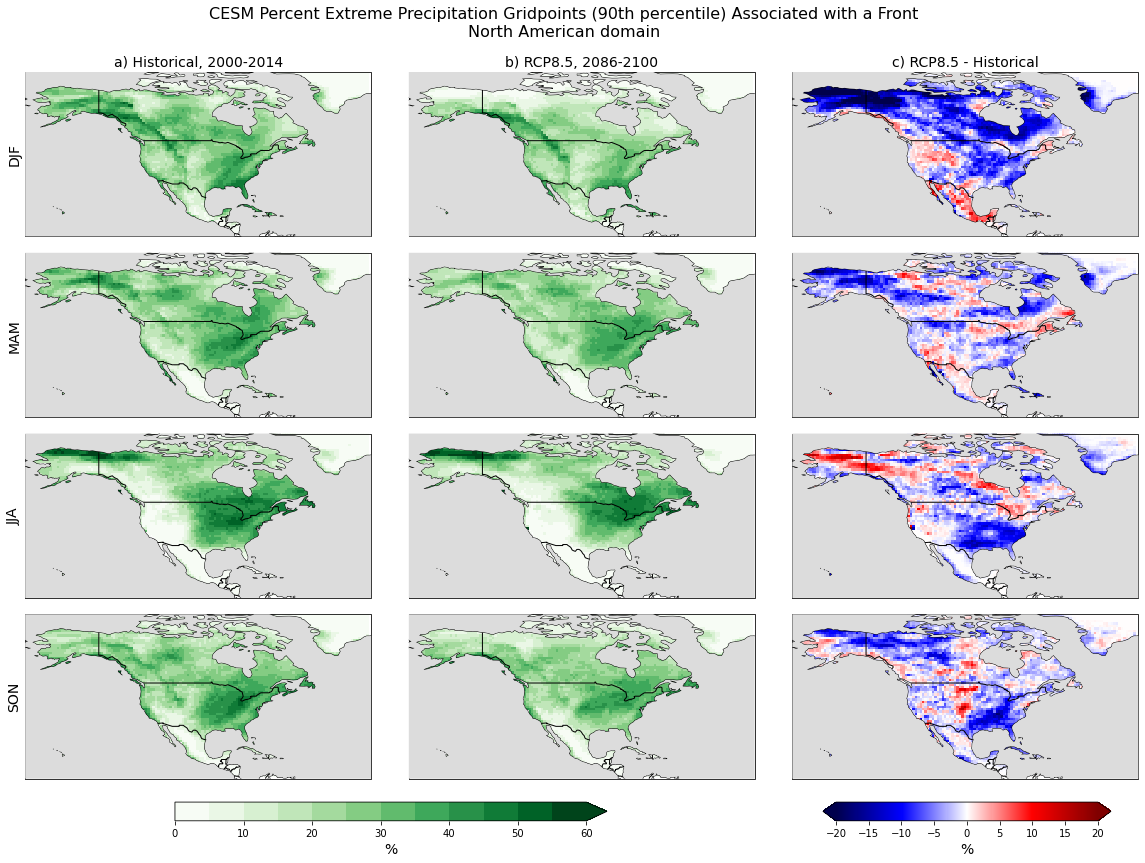

In [33]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
vmax = 60

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(npercentPEx_time_byseason.sel(season=season), coord=npercentPEx_time_byseason.lon)
    lat = npercentPEx_time_byseason.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_byseason_rcp.sel(season=season), coord=npercentPEx_time_byseason_rcp.lon)
    lat = npercentPEx_time_byseason_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-20
vmax2=20

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_byseason_diff.sel(season=season), coord=npercentPEx_time_byseason_diff.lon)
    lat = npercentPEx_time_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Front\nNorth American domain', fontsize=16, y=0.95)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_byseason_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_byseason_diff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_byseason_diff_alterbase_landonly.png', bbox_inches='tight')

#### CONUS domain

In [69]:
npercentPEx_time_CONUS_byseason = npercentPEx_time_CONUS_byseason.persist()
npercentPEx_time_CONUS_byseason_rcp = npercentPEx_time_CONUS_byseason_rcp.persist()

In [35]:
npercentPEx_time_CONUS_byseason.max().values

array(54.37415882)

In [36]:
npercentPEx_time_CONUS_byseason_rcp.max().values

array(51.63551402)

In [70]:
npercentPEx_time_CONUS_byseason_diff = npercentPEx_time_CONUS_byseason_rcp - npercentPEx_time_CONUS_byseason

In [38]:
npercentPEx_time_CONUS_byseason_diff.max().values

array(17.02748896)

In [39]:
npercentPEx_time_CONUS_byseason_diff.min().values

array(-25.)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


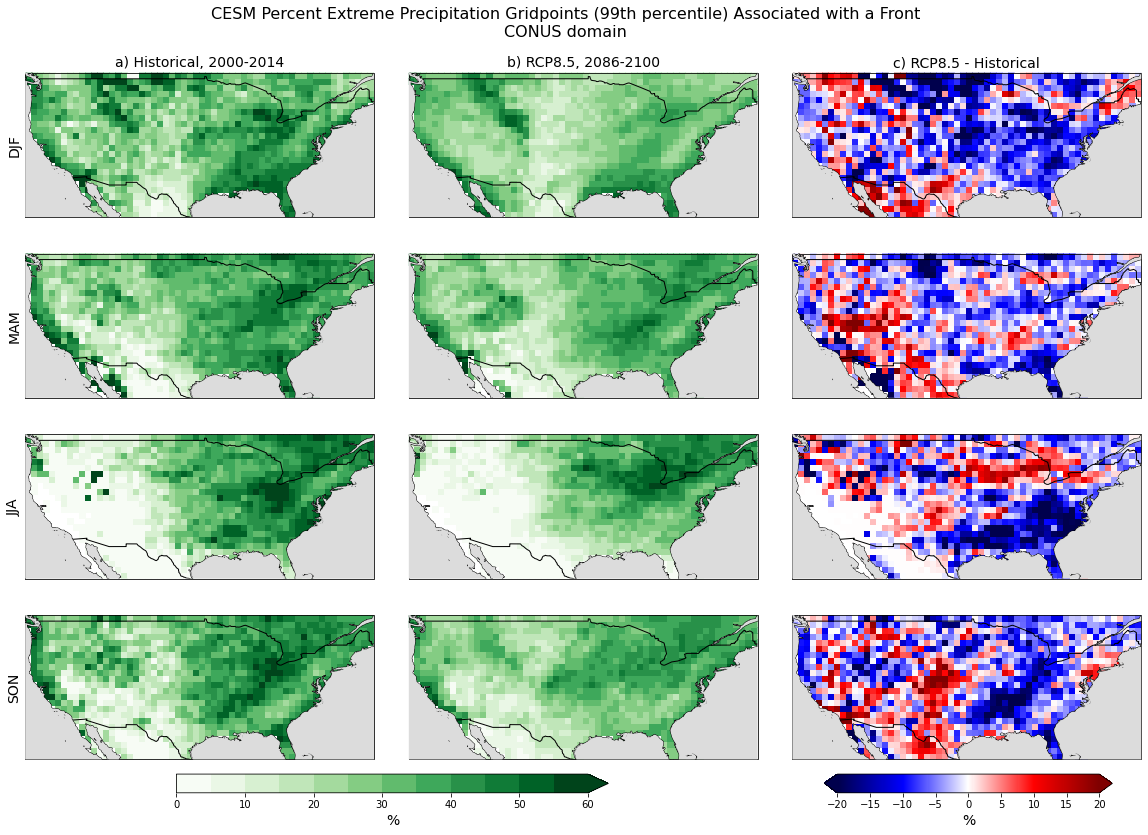

In [71]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
vmax = 60 # 90,95th percentiles and 99th percentile land only
#vmax = 70 # 99th percentile - note need to fix this for all gridpoints (number of discrete colors)

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason.sel(season=season), coord=npercentPEx_time_CONUS_byseason.lon)
    lat = npercentPEx_time_CONUS_byseason.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_rcp.sel(season=season), coord=npercentPEx_time_CONUS_byseason_rcp.lon)
    lat = npercentPEx_time_CONUS_byseason_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal') # extend not strictly needed for land only points, 90th percentile
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
# 90, 95th percentiles and 99th percentile land only
vmin2=-20
vmax2=20
# 99th percentile all gridpoints
#vmin2=-40
#vmax2=40

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Front\nCONUS domain', fontsize=16, y=0.94)
#fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (95th percentile) Associated with a Front\nCONUS domain', fontsize=16, y=0.94)
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (99th percentile) Associated with a Front\nCONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_byseason_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff.png', bbox_inches='tight')
# plots with altered PEx baseline for RCP simulation
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_alterbase.png', bbox_inches='tight')
# plot with PRECT conservative regridding
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_alterbase_consregrid.png', bbox_inches='tight')
# plot land points only
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_alterbase_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_alterbase_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_alterbase_landonly.png', bbox_inches='tight')

#### Cold fronts

In [167]:
npercentPEx_c_time_CONUS_byseason = npercentPEx_c_time_CONUS_byseason.persist()
npercentPEx_c_time_CONUS_byseason_rcp = npercentPEx_c_time_CONUS_byseason_rcp.persist()

In [168]:
npercentPEx_c_time_CONUS_byseason.max().values

array(29.61165049)

In [169]:
npercentPEx_c_time_CONUS_byseason_rcp.max().values

array(33.05785124)

In [55]:
npercentPEx_c_time_CONUS_byseason_diff = npercentPEx_c_time_CONUS_byseason_rcp - npercentPEx_c_time_CONUS_byseason

In [171]:
npercentPEx_c_time_CONUS_byseason_diff.max().values

array(17.62153913)

In [172]:
npercentPEx_c_time_CONUS_byseason_diff.min().values

array(-15.93023256)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


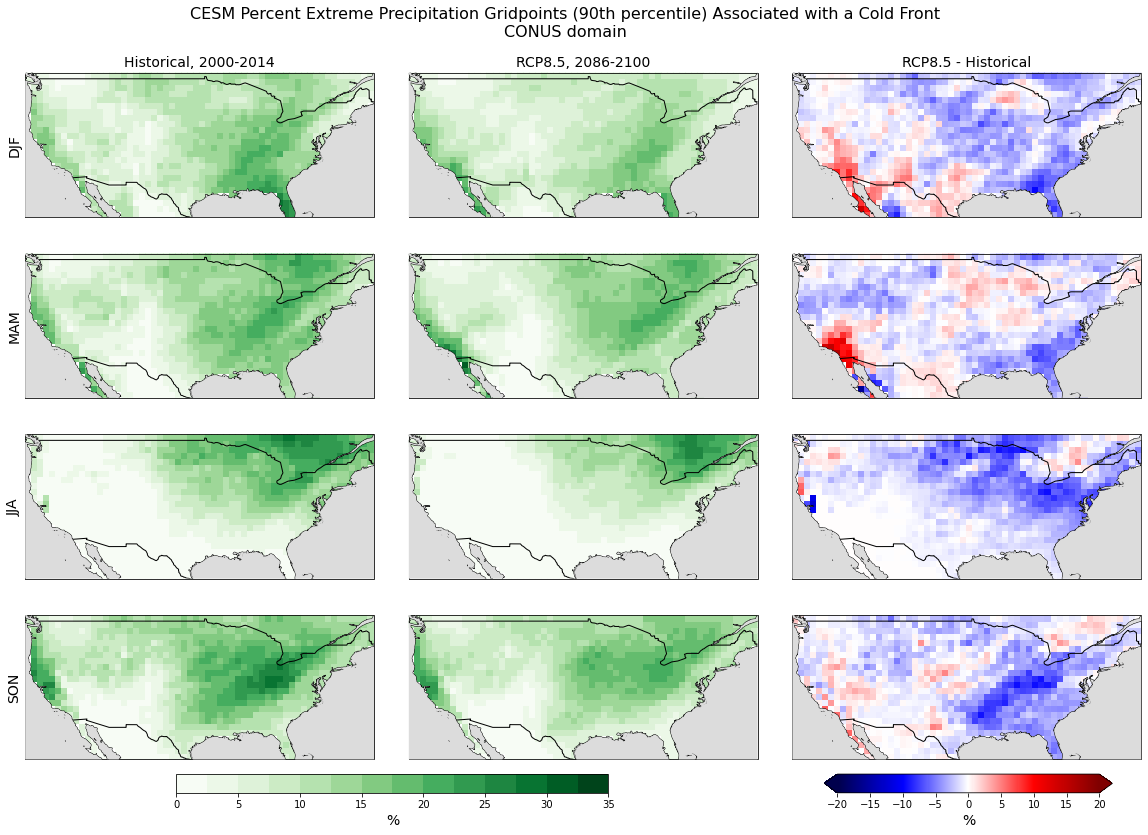

In [173]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
#cmap=plt.cm.get_cmap('Greens',16) # 90th percentile
cmap=plt.cm.get_cmap('Greens',14) # 90th percentile, land only
#vmax = 40 # 90th percentile
vmax = 35 # 90th percentile, land only

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(npercentPEx_c_time_CONUS_byseason.sel(season=season), coord=npercentPEx_c_time_CONUS_byseason.lon)
    lat = npercentPEx_c_time_CONUS_byseason.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_c_time_CONUS_byseason_rcp.sel(season=season), coord=npercentPEx_c_time_CONUS_byseason_rcp.lon)
    lat = npercentPEx_c_time_CONUS_byseason_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal') # extend not needed for land only points
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
# 90, 95th percentiles
vmin2=-20
vmax2=20
# 99th percentile
#vmin2=-40
#vmax2=40

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_c_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_c_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_c_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Cold Front\nCONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_cold_fronts.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_cold_fronts_landonly.png', bbox_inches='tight')

#### Stationary fronts

In [108]:
npercentPEx_s_time_CONUS_byseason = npercentPEx_s_time_CONUS_byseason.persist()
npercentPEx_s_time_CONUS_byseason_rcp = npercentPEx_s_time_CONUS_byseason_rcp.persist()

In [109]:
npercentPEx_s_time_CONUS_byseason.max().values

array(38.2540461)

In [110]:
npercentPEx_s_time_CONUS_byseason_rcp.max().values

array(37.80007166)

In [56]:
npercentPEx_s_time_CONUS_byseason_diff = npercentPEx_s_time_CONUS_byseason_rcp - npercentPEx_s_time_CONUS_byseason

In [112]:
npercentPEx_s_time_CONUS_byseason_diff.max().values

array(12.53209669)

In [113]:
npercentPEx_s_time_CONUS_byseason_diff.min().values

array(-25.)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


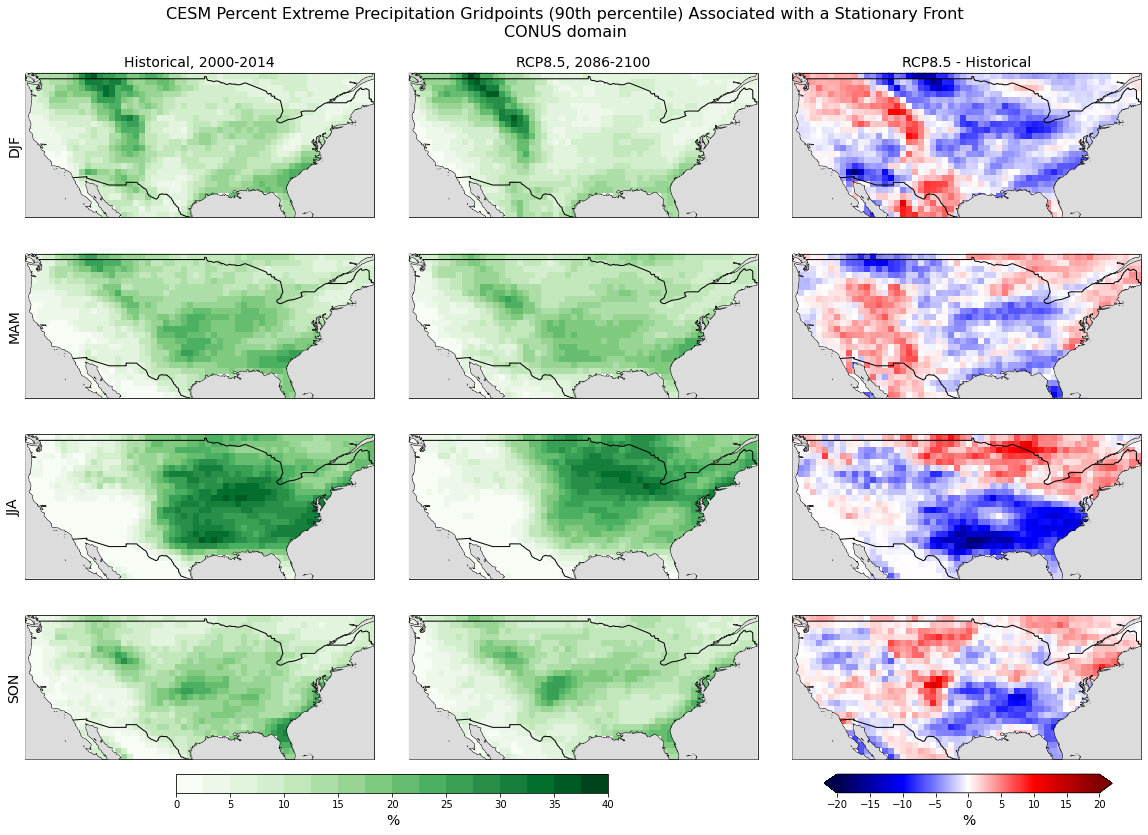

In [180]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens',16)
vmax = 40 # 90th percentile

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(npercentPEx_s_time_CONUS_byseason.sel(season=season), coord=npercentPEx_s_time_CONUS_byseason.lon)
    lat = npercentPEx_s_time_CONUS_byseason.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_s_time_CONUS_byseason_rcp.sel(season=season), coord=npercentPEx_s_time_CONUS_byseason_rcp.lon)
    lat = npercentPEx_s_time_CONUS_byseason_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal') # extend not needed for land only points
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
# 90th percentile
vmin2=-20
vmax2=20

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_s_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_s_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_s_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Percent Extreme Precipitation Gridpoints (90th percentile) Associated with a Stationary Front\nCONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_stationary_fronts.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_stationary_fronts_landonly.png', bbox_inches='tight')

### Adding PEx grid/time point plots

In [73]:
# masking ocean points for correlation coefficients
PExgridpoints_time_CONUS_byseason = PExgridpoints_time_CONUS_byseason.where(landfrac > 0)
PExgridpoints_time_CONUS_byseason_rcp = PExgridpoints_time_CONUS_byseason_rcp.where(landfrac > 0)

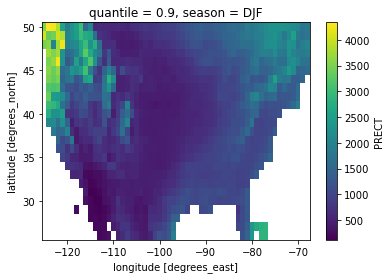

In [42]:
PExgridpoints_time_CONUS_byseason.sel(season='DJF').plot()

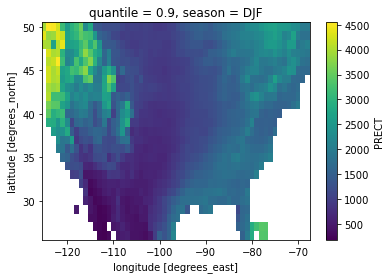

In [43]:
PExgridpoints_time_CONUS_byseason_rcp.sel(season='DJF').plot()

In [74]:
# calculating the % changes in PEx (w/o fronts)
PExgridpoints_time_CONUS_byseason_perdiff = 100*(PExgridpoints_time_CONUS_byseason_rcp - PExgridpoints_time_CONUS_byseason)/PExgridpoints_time_CONUS_byseason

In [75]:
# persist for plotting
PExgridpoints_time_CONUS_byseason_perdiff = PExgridpoints_time_CONUS_byseason_perdiff.persist()

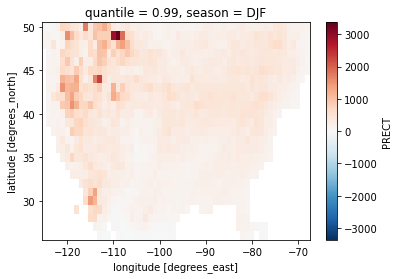

In [76]:
PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF').plot()

In [49]:
# sanity check there are nans where there should be
PExgridpoints_time_CONUS_byseason_perdiff.sel(lon=-70, lat=26, method='nearest').sel(season='DJF').values

array(nan)

In [ ]:
# absolute changes (units = number of gridpoints, not that helpful to visualize)
PExgridpoints_time_CONUS_byseason_diff = PExgridpoints_time_CONUS_byseason_rcp - PExgridpoints_time_CONUS_byseason
PExgridpoints_time_CONUS_byseason_diff = PExgridpoints_time_CONUS_byseason_diff.persist()

### Calculating the changes in fronts (usually done in a different notebook)

In [47]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def srates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    srates_clim = rates_fronts.seasonal_rate_climatology
    srates_clim_stdev = rates_fronts.seasonal_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(srates_clim_CONUS.lat))
    weights.name = "weights"
    srates_clim_CONUS_weighted = srates_clim_CONUS.weighted(weights)
    srates_clim_CONUS_weighted_mean = srates_clim_CONUS_weighted.mean(("lon","lat"))
    srates_clim_stdev_CONUS_weighted = srates_clim_stdev_CONUS.weighted(weights)
    srates_clim_stdev_CONUS_weighted_mean = srates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(srates_clim_CONUS, srates_clim_stdev_CONUS, srates_clim_CONUS_weighted_mean, srates_clim_stdev_CONUS_weighted_mean)

In [48]:
# cesm rates with a modified 15-year climatology to match RCP #years (2000-2014)
cesm_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
cesm_fullmod_rates_file = "cesm_fronts_2000-2014_frontRates_viaPolylines_customgrid.nc"
cesm_fullmod_srates_clim_CONUS, cesm_fullmod_srates_clim_stdev_CONUS, cesm_fullmod_srates_clim_CONUS_mean, cesm_fullmod_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_fullmod_rates_file, "MERRA")

# cesm rcp8.5 results
cesm_rcp85_rates_file = "cesm_fronts_2086-2100_frontRates_viaPolylines_customgrid.nc" # generated via poylines
cesm_rcp85_srates_clim_CONUS, cesm_rcp85_srates_clim_stdev_CONUS, cesm_rcp85_srates_clim_CONUS_mean, cesm_rcp85_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_rcp85_rates_file, "MERRA")

cesm_srates_clim_CONUS_diff = cesm_rcp85_srates_clim_CONUS - cesm_fullmod_srates_clim_CONUS

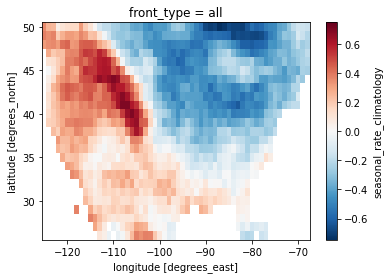

In [49]:
# mask the front rate diffs to match
cesm_srates_clim_CONUS_diff_land = cesm_srates_clim_CONUS_diff.where(landfrac > 0)
(cesm_srates_clim_CONUS_diff_land*7)[0,4,:,:].plot()

In [53]:
# sanity check there are nans where there should be
cesm_srates_clim_CONUS_diff_land.sel(lon=-70, lat=26, method='nearest')

<xarray.DataArray 'seasonal_rate_climatology' (seasons4: 4, front: 5)>
array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)
Coordinates:
    lat         float64 26.0
    lon         float64 -70.0
    front_type  (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: seasons4, front

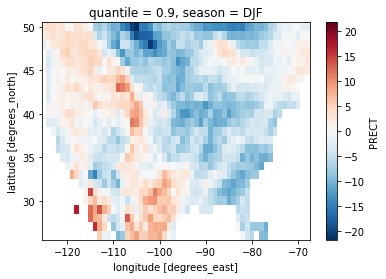

In [50]:
# this is already a masked array so everything going into spearman calculation should be masked
npercentPEx_time_CONUS_byseason_diff.sel(season='DJF').plot()

In [55]:
# sanity check there are nans where there should be
npercentPEx_time_CONUS_byseason_diff.sel(lon=-70, lat=26, method='nearest').sel(season='DJF').values

array(nan)

In [51]:
# calculating spearman rank correlations to add to plots; axis=None doesn't change results but nan_policy='omit' DOES!
test_spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), y=(cesm_srates_clim_CONUS_diff_land*7)[0,4,:,:], axis=None, nan_policy='omit')
test_spear

SpearmanrResult(correlation=0.6785366416803167, pvalue=1.9065732036221934e-155)

In [52]:
test_spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), y=PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'), axis=None, nan_policy='omit')
test_spear

SpearmanrResult(correlation=-0.19008647684387253, pvalue=8.748277397804185e-11)

In [228]:
# For spearmanr: If axis=0 (default), then each column (lon) represents a variable, with observations in the rows (lats). 
npercentPEx_time_CONUS_byseason_diff

<xarray.DataArray 'PRECT' (season: 4, lat: 25, lon: 58)>
dask.array<sub, shape=(4, 25, 58), dtype=float64, chunksize=(1, 10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
    quantile  float64 0.9
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [194]:
# string formatting for correlation labels
spearstr = r'$\rho$ = '+str(round(test_spear.correlation,2))
spearstr

'$\\rho$ = -0.05'

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


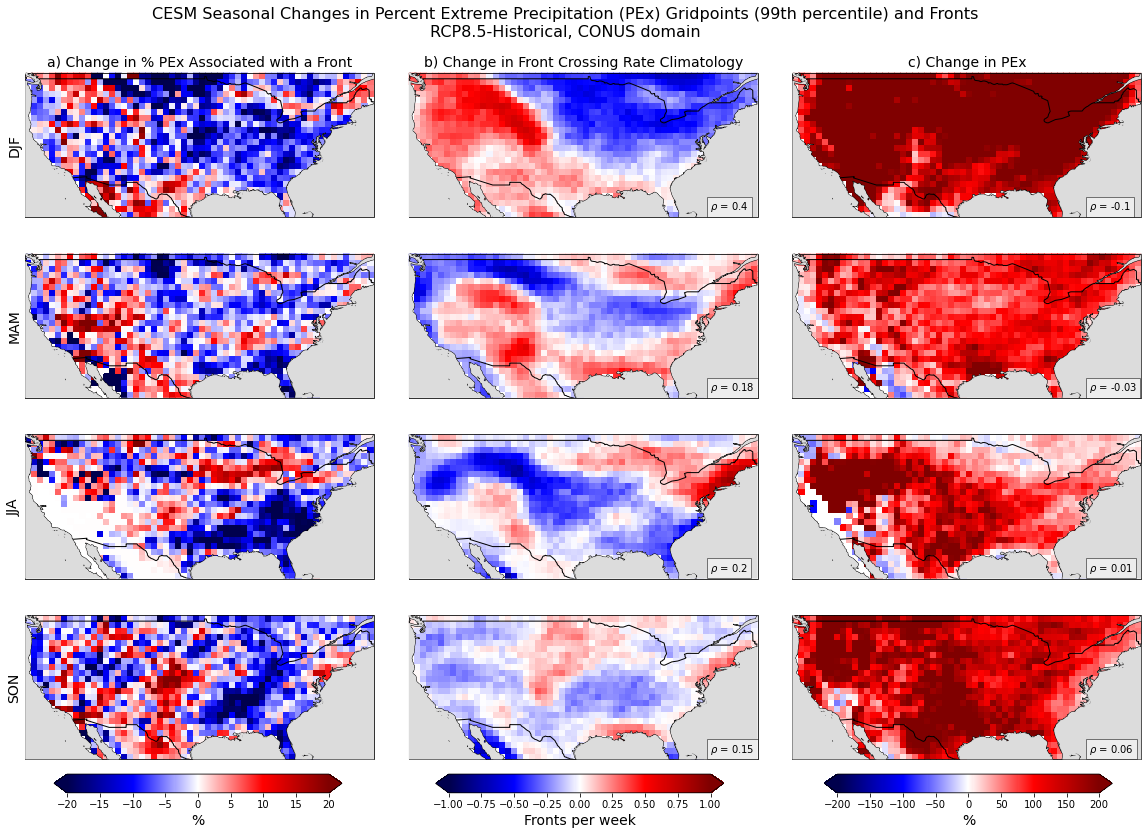

In [77]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# seasons
sea_strs = ('DJF', 'MAM', 'JJA', 'SON')

# colormap for diff plots
cmap = plt.cm.get_cmap('seismic')
# 90, 95th percentiles and 99th percentile land only
vmin1=-20
vmax1=20
# 99th percentile all gridpoints
#vmin1=-40
#vmax1=40

# first panel: change in PEx and Front
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,0].set_title('a) Change in % PEx Associated with a Front', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_time_CONUS_byseason_diff.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    
# add colorbar for first panel
cb1_ax = fig.add_axes([0.145, 0.1, 0.2, 0.02])
norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm1, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('%', fontsize=14)
    
# second panel: change in fronts    
vmin2=-1
vmax2=1
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,1].set_title('b) Change in Front Crossing Rate Climatology', fontsize=14) 
    #field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,4,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff_land*7)[i,4,:,:], coord=cesm_srates_clim_CONUS_diff_land.lon) # land only for correlation coefficients
    #lat = cesm_srates_clim_CONUS_diff.lat
    lat = cesm_srates_clim_CONUS_diff_land.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season=season), y=(cesm_srates_clim_CONUS_diff*7)[i,4,:,:])
    spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season=season), y=(cesm_srates_clim_CONUS_diff_land*7)[i,4,:,:], nan_policy='omit')
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,1].text(0.865, 0.05, spearstr, transform=axs[i,1].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5), zorder=4)
    
cb2_ax = fig.add_axes([0.41, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Fronts per week', fontsize=14)

# third panel: change in PEx 
# 90, 95th percentiles
#vmin3=-100
#vmax3=100
# 99th percentile
vmin3=-200
vmax3=200
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,2].set_title('c) Change in PEx', fontsize=14)
    field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_perdiff.lon)
    lat = PExgridpoints_time_CONUS_byseason_perdiff.lat
    #field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_diff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_diff.lon)
    #lat = PExgridpoints_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    spear = stats.mstats.spearmanr(x=npercentPEx_time_CONUS_byseason_diff.sel(season=season), y=PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), nan_policy='omit')
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    #axs[i,2].text(0.85, 0.05, spearstr, transform=axs[i,2].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5))
    axs[i,2].text(0.85, 0.05, spearstr, transform=axs[i,2].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5), zorder=4) # land only
    
cb3_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap=cmap, norm=norm3, orientation='horizontal', extend='both')
cb3.ax.set_xlabel('%', fontsize=14)  
    
# add title
#fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (90th percentile) and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)
#fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (95th percentile) and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)
fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (99th percentile) and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr.png', bbox_inches='tight')
# plots with altered PEx baseline for RCP simulation
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase.png', bbox_inches='tight')
# plot with PRECT conservative regridding
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase_consregrid.png', bbox_inches='tight')
# plot land points only
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx95_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase_landonly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx99_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_alterbase_landonly.png', bbox_inches='tight')

#### Cold fronts

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


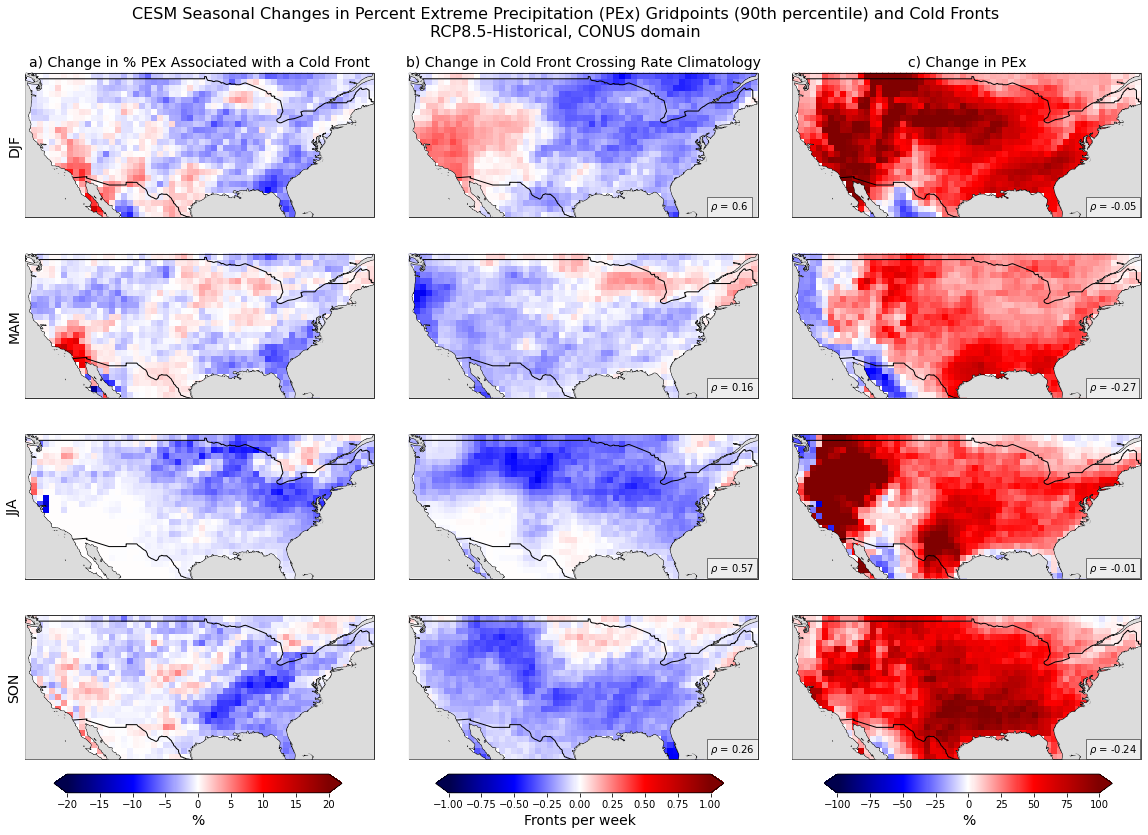

In [57]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# seasons
sea_strs = ('DJF', 'MAM', 'JJA', 'SON')

# colormap for diff plots
cmap = plt.cm.get_cmap('seismic')
# 90th percentile
vmin1=-20
vmax1=20

# first panel: change in PEx and Front
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,0].set_title('a) Change in % PEx Associated with a Cold Front', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_c_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_c_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_c_time_CONUS_byseason_diff.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    
# add colorbar for first panel
cb1_ax = fig.add_axes([0.145, 0.1, 0.2, 0.02])
norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm1, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('%', fontsize=14)
    
# second panel: change in fronts    
vmin2=-1
vmax2=1
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,1].set_title('b) Change in Cold Front Crossing Rate Climatology', fontsize=14) 
    #field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,0,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff_land*7)[i,0,:,:], coord=cesm_srates_clim_CONUS_diff_land.lon) # land only for correlation coefficients
    #lat = cesm_srates_clim_CONUS_diff.lat
    lat = cesm_srates_clim_CONUS_diff_land.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #spear = stats.mstats.spearmanr(x=npercentPEx_c_time_CONUS_byseason_diff.sel(season=season), y=(cesm_srates_clim_CONUS_diff*7)[i,0,:,:])
    spear = stats.mstats.spearmanr(x=npercentPEx_c_time_CONUS_byseason_diff.sel(season=season), y=(cesm_srates_clim_CONUS_diff_land*7)[i,0,:,:], nan_policy='omit')
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,1].text(0.865, 0.05, spearstr, transform=axs[i,1].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5), zorder=4)
    
cb2_ax = fig.add_axes([0.41, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Fronts per week', fontsize=14)

# third panel: change in PEx 
# 90th percentile
vmin3=-100
vmax3=100

for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,2].set_title('c) Change in PEx', fontsize=14)
    field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_perdiff.lon)
    lat = PExgridpoints_time_CONUS_byseason_perdiff.lat
    #field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_diff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_diff.lon)
    #lat = PExgridpoints_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    spear = stats.mstats.spearmanr(x=npercentPEx_c_time_CONUS_byseason_diff.sel(season=season), y=PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), nan_policy='omit')
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,2].text(0.85, 0.05, spearstr, transform=axs[i,2].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5), zorder=4)
    
cb3_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap=cmap, norm=norm3, orientation='horizontal', extend='both')
cb3.ax.set_xlabel('%', fontsize=14)  
    
# add title
fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (90th percentile) and Cold Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_cold_fronts.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_cold_fronts_landonly.png', bbox_inches='tight')

#### Stationary fronts

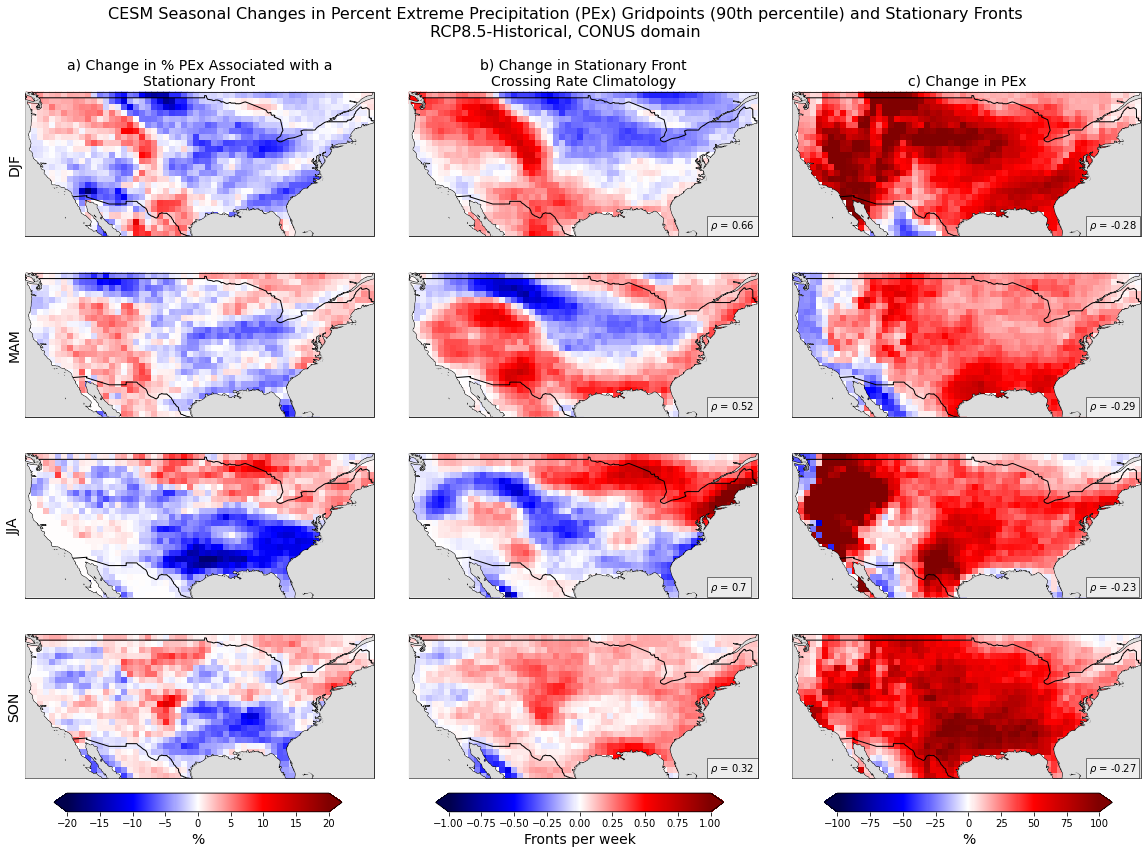

In [58]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# seasons
sea_strs = ('DJF', 'MAM', 'JJA', 'SON')

# colormap for diff plots
cmap = plt.cm.get_cmap('seismic')
# 90th percentile
vmin1=-20
vmax1=20

# first panel: change in PEx and Front
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,0].set_title('a) Change in % PEx Associated with a\nStationary Front', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_s_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_s_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_s_time_CONUS_byseason_diff.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    
# add colorbar for first panel
cb1_ax = fig.add_axes([0.145, 0.1, 0.2, 0.02])
norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm1, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('%', fontsize=14)
    
# second panel: change in fronts    
vmin2=-1
vmax2=1
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,1].set_title('b) Change in Stationary Front\nCrossing Rate Climatology', fontsize=14) 
    #field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,2,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff_land*7)[i,2,:,:], coord=cesm_srates_clim_CONUS_diff_land.lon)
    #lat = cesm_srates_clim_CONUS_diff.lat
    lat = cesm_srates_clim_CONUS_diff_land.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #spear = stats.mstats.spearmanr(x=npercentPEx_s_time_CONUS_byseason_diff.sel(season=season), y=(cesm_srates_clim_CONUS_diff*7)[i,2,:,:])
    spear = stats.mstats.spearmanr(x=npercentPEx_s_time_CONUS_byseason_diff.sel(season=season), y=(cesm_srates_clim_CONUS_diff_land*7)[i,2,:,:], nan_policy='omit')
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,1].text(0.865, 0.05, spearstr, transform=axs[i,1].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5), zorder=4)
    
cb2_ax = fig.add_axes([0.41, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Fronts per week', fontsize=14)

# third panel: change in PEx 
# 90th percentile
vmin3=-100
vmax3=100
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,2].set_title('c) Change in PEx', fontsize=14)
    field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_perdiff.lon)
    lat = PExgridpoints_time_CONUS_byseason_perdiff.lat
    #field, lon = add_cyclic_point(PExgridpoints_time_CONUS_byseason_diff.sel(season=season), coord=PExgridpoints_time_CONUS_byseason_diff.lon)
    #lat = PExgridpoints_time_CONUS_byseason_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    spear = stats.mstats.spearmanr(x=npercentPEx_s_time_CONUS_byseason_diff.sel(season=season), y=PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), nan_policy='omit')
    spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,2].text(0.85, 0.05, spearstr, transform=axs[i,2].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5), zorder=4)
    
cb3_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap=cmap, norm=norm3, orientation='horizontal', extend='both')
cb3.ax.set_xlabel('%', fontsize=14)  
    
# add title
fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints (90th percentile) and Stationary Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.96)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_stationary_fronts.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx90_time_CONUS_byseason_diff_withfronts_andPEx_andspearmanr_stationary_fronts_landonly.png', bbox_inches='tight')

In [45]:
# Other plotting ideas
# first panel: change in PEx and Front as above

# second panel: spatial pattern correlation of front frequency with first panel (as a map)

# third panel: spatial pattern correlation of change in PEx with first panel (as a map)

# Also, could look at high-res (0.25deg) version of panel c) to investigate changes in PEx in the model

In [34]:
# spatial pattern correlation
from scipy import signal
corr_test = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'), mode='same', boundary='fill')
corr_test
# how to interpret these numbers? do they need to be rescaled/normalized somehow?

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

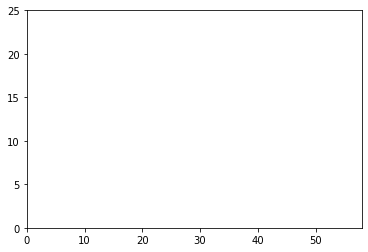

In [35]:
plt.pcolor(corr_test)

In [36]:
# mode='valid' gives a single number?
corr_test = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'), mode='valid', boundary='fill')
corr_test

array([[nan]])

In [37]:
# what is the difference using boundary='symm'? output is definitely different
corr_symm = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), PExgridpoints_time_CONUS_byseason_perdiff.sel(season='DJF'), mode='same', boundary='symm')
corr_symm
# also a boundary='wrap' option...

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

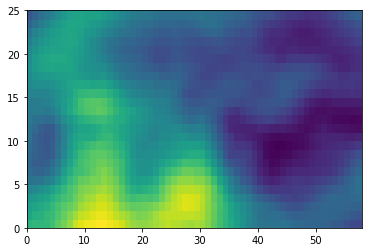

In [66]:
plt.pcolor(corr_symm)

In [68]:
corr_test_fronts = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season='DJF'), cesm_srates_clim_CONUS_diff[0,4,:,:], mode='same', boundary='fill')
corr_test_fronts
# scale of numbers is very different here

array([[-34.02684229, -31.02508938, -29.19678615, ..., -26.06786052,
        -31.97249809, -37.20272489],
       [-31.64991679, -28.15192885, -25.16184323, ..., -34.59658333,
        -40.20643337, -45.04836551],
       [-29.51567704, -25.66565864, -21.99386837, ..., -42.93102423,
        -48.2888662 , -52.62923128],
       ...,
       [ 26.74445842,  30.69230389,  34.45933308, ..., -83.25288607,
        -80.10881936, -75.22622885],
       [ 24.25894999,  27.14500036,  30.34352987, ..., -74.024844  ,
        -71.42070505, -67.01065928],
       [ 19.99890707,  22.85529487,  25.35927075, ..., -64.95092391,
        -63.06845199, -58.99291268]])

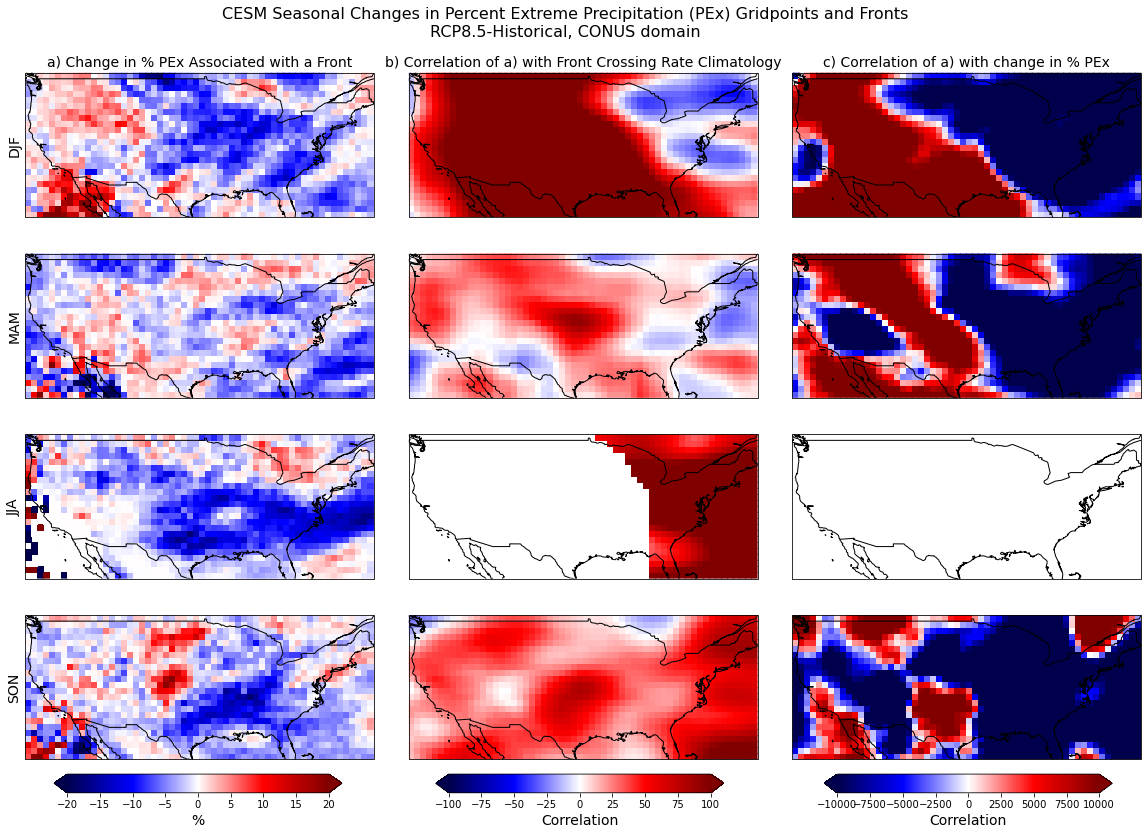

In [71]:
# scales are a bit weird here, especially for correlations of percentage diffs
# also some seasons don't plot / get cut off?
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# seasons
sea_strs = ('DJF', 'MAM', 'JJA', 'SON')

# colormap for diff plots
cmap = plt.cm.get_cmap('seismic')
vmin1=-20
vmax1=20

# first panel: change in PEx and Front
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,0].set_title('a) Change in % PEx Associated with a Front', fontsize=14)
    field, lon = add_cyclic_point(npercentPEx_time_CONUS_byseason_diff.sel(season=season), coord=npercentPEx_time_CONUS_byseason_diff.lon)
    lat = npercentPEx_time_CONUS_byseason_diff.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    
# add colorbar for first panel
cb1_ax = fig.add_axes([0.145, 0.1, 0.2, 0.02])
norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm1, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('%', fontsize=14)
    
# second panel: change in fronts correlation with first panel  
vmin2=-100
vmax2=100
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,1].set_title('b) Correlation of a) with Front Crossing Rate Climatology', fontsize=14) 
    corr = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season=season), cesm_srates_clim_CONUS_diff[i,4,:,:], mode='same', boundary='symm')
    field, lon = add_cyclic_point(corr, coord=cesm_srates_clim_CONUS_diff.lon)
    lat = cesm_srates_clim_CONUS_diff.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb2_ax = fig.add_axes([0.41, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Correlation', fontsize=14)

# third panel: change in PEx correlation with first panel
vmin3=-10000
vmax3=10000
for i, season in enumerate(sea_strs):
    if i == 0:
        axs[i,2].set_title('c) Correlation of a) with change in % PEx', fontsize=14)
    corr = signal.correlate2d(npercentPEx_time_CONUS_byseason_diff.sel(season=season), PExgridpoints_time_CONUS_byseason_perdiff.sel(season=season), mode='same', boundary='symm')
    field, lon = add_cyclic_point(corr, coord=PExgridpoints_time_CONUS_byseason_perdiff.lon)
    lat = PExgridpoints_time_CONUS_byseason_perdiff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    
cb3_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap=cmap, norm=norm3, orientation='horizontal', extend='both')
cb3.ax.set_xlabel('Correlation', fontsize=14)  


    
# add title
fig.suptitle('CESM Seasonal Changes in Percent Extreme Precipitation (PEx) Gridpoints and Fronts\nRCP8.5-Historical, CONUS domain', fontsize=16, y=0.94)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentPEx_time_CONUS_byseason_diff_withfronts_andPEx.png', bbox_inches='tight')

In [78]:
client.close()
cluster.close()